# Topology (Persistent Homology) Detector on Tabular + Vector Data

This notebook evaluates the repo’s **topology-based detector** (`detector_type='topology_score'`) on:

1. **Tabular data**: a real binary dataset (Breast Cancer Wisconsin).
2. **Vector data**: a synthetic high-dimensional binary dataset.

For each dataset we:

- train a classifier (MLP),
- generate adversarial examples (FGSM/PGD),
- compute topology (persistent homology) features on local neighborhoods,
- fit a topology-score detector on validation scores,
- report detection metrics (AUROC/AUPRC/FPR@95%TPR).



In [ ]:
# Imports + path setup + dependency checks
import os
import sys
import importlib
import numpy as np

# Project root
CWD = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CWD, "..")) if os.path.basename(CWD) == "notebooks" else os.path.abspath(CWD)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# PH backend check
try:
    importlib.import_module("ripser")
    print("ripser is available")
except Exception as e:
    raise ImportError(
        "ripser is required for this notebook. Install into this Jupyter kernel env:\n"
        "  python -m pip install ripser\n"
        "Then restart the kernel and rerun."
    ) from e

import torch
import matplotlib.pyplot as plt

from src.data import create_data_loaders, load_breast_cancer_tabular
from src.models import TwoMoonsMLP, train_model, evaluate_model, extract_features_batch, get_model_logits, get_model_predictions
from src.adv_attacks import generate_adversarial_examples
from src.graph_scoring import compute_graph_scores
from src.detectors import train_graph_detector
from src.evaluation import evaluate_detector
from src.utils import ExperimentConfig, set_seed

print(f"CWD: {CWD}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")



ripser is available
CWD: /Users/svenhockers/Documents/code_files/topology-and-robustness-in-DNNs/notebooks
PROJECT_ROOT: /Users/svenhockers/Documents/code_files/topology-and-robustness-in-DNNs


In [ ]:
# Helpers
from typing import Dict, Tuple
from sklearn.neighbors import NearestNeighbors

from src.topology_features import TopologyConfig, local_persistence_features
from src.data import split_and_scale, generate_synthetic_vector_classification


def compute_topology_feature_scores(
    X_points: np.ndarray,
    *,
    model,
    Z_train: np.ndarray,
    graph_cfg,
    device: str,
    layer: str = 'penultimate',
) -> Dict[str, np.ndarray]:
    """Compute only topo_* features for a batch of points.

    This avoids the heavy geometric score computation in compute_graph_scores, but uses
    the same neighborhood definition and PH feature computation as the repo.
    """
    if graph_cfg.space == 'feature':
        Z_points = extract_features_batch(model, X_points, layer=layer, device=device)
    else:
        Z_points = X_points

    topo_cfg = TopologyConfig(
        neighborhood_k=int(getattr(graph_cfg, 'topo_k', 50)),
        maxdim=int(getattr(graph_cfg, 'topo_maxdim', 1)),
        metric=str(getattr(graph_cfg, 'topo_metric', 'euclidean')),
        thresh=getattr(graph_cfg, 'topo_thresh', None),
        min_persistence=float(getattr(graph_cfg, 'topo_min_persistence', 1e-6)),
        preprocess=str(getattr(graph_cfg, 'topo_preprocess', 'none')),
        pca_dim=int(getattr(graph_cfg, 'topo_pca_dim', 5)),
    )

    nbrs = NearestNeighbors(
        n_neighbors=min(topo_cfg.neighborhood_k, len(Z_train)),
        metric=topo_cfg.metric,
    ).fit(Z_train)

    feat_dicts = []
    for i in range(len(Z_points)):
        _, idx = nbrs.kneighbors(Z_points[i].reshape(1, -1))
        neighborhood = Z_train[idx[0]]
        cloud = np.vstack([Z_points[i].reshape(1, -1), neighborhood])
        feat_dicts.append(local_persistence_features(cloud, topo_cfg))

    all_keys = sorted({k for d in feat_dicts for k in d.keys()})
    return {k: np.array([d.get(k, 0.0) for d in feat_dicts], dtype=float) for k in all_keys}


def concat_scores(scores_a: Dict[str, np.ndarray], scores_b: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    keys = sorted(set(scores_a.keys()) | set(scores_b.keys()))
    out = {}
    for k in keys:
        a = scores_a.get(k)
        b = scores_b.get(k)
        if a is None:
            a = np.zeros(len(next(iter(scores_a.values()))), dtype=float)
        if b is None:
            b = np.zeros(len(next(iter(scores_b.values()))), dtype=float)
        out[k] = np.concatenate([a, b])
    return out



In [ ]:
# Experiment runner (topology detector)

def run_topology_detector_experiment(
    X: np.ndarray,
    y: np.ndarray,
    *,
    name: str,
    seed: int = 42,
    attack_type: str = 'fgsm',
    epsilon: float = 0.1,
    max_points_for_scoring: int = 400,
):
    set_seed(seed)

    X_train, y_train, X_val, y_val, X_test, y_test, scaler = split_and_scale(X, y, seed=seed)
    X_train = np.asarray(X_train, dtype=float); y_train = np.asarray(y_train, dtype=int)
    X_val = np.asarray(X_val, dtype=float); y_val = np.asarray(y_val, dtype=int)
    X_test = np.asarray(X_test, dtype=float); y_test = np.asarray(y_test, dtype=int)

    # Config
    config = ExperimentConfig(seed=seed, device='cpu')
    config.model.input_dim = int(X_train.shape[1])
    config.model.hidden_dims = [128, 64]
    config.model.epochs = 80
    config.model.learning_rate = 1e-3

    config.attack.attack_type = str(attack_type)
    config.attack.epsilon = float(epsilon)
    config.attack.num_steps = 30
    config.attack.step_size = float(epsilon) / 10.0
    config.attack.random_start = True

    # Topology neighborhoods computed in feature space
    config.graph.space = 'feature'
    config.graph.use_topology = True
    config.graph.use_tangent = False  # we only need topology features here
    config.graph.topo_k = 40
    config.graph.topo_maxdim = 1
    config.graph.topo_min_persistence = 1e-6
    # Option 1: local PCA before PH (helps in high-d tabular/vector settings)
    config.graph.topo_preprocess = 'pca'
    config.graph.topo_pca_dim = 10

    config.detector.detector_type = 'topology_score'
    config.detector.topo_percentile = 95.0
    config.detector.topo_cov_shrinkage = 1e-3

    # Data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=config.model.batch_size
    )

    model = TwoMoonsMLP(
        input_dim=config.model.input_dim,
        hidden_dims=config.model.hidden_dims,
        output_dim=2,
        activation=config.model.activation,
    )

    history = train_model(model, train_loader, val_loader, config.model, device=config.device, verbose=False)
    test_loss, test_acc = evaluate_model(model, test_loader, device=config.device)

    # Reference feature-space set
    Z_train = extract_features_batch(model, X_train, layer='penultimate', device=config.device)
    logits_train = get_model_logits(model, X_train, device=config.device)
    probs_train = torch.softmax(torch.as_tensor(logits_train, dtype=torch.float32), dim=1).cpu().numpy()
    f_train = probs_train[:, 1]

    # Adversarial examples
    X_adv_val = generate_adversarial_examples(model, X_val, y_val, config.attack, device=config.device)
    X_adv_test = generate_adversarial_examples(model, X_test, y_test, config.attack, device=config.device)

    # Subsample for scoring to keep runtime reasonable
    rng = np.random.default_rng(seed)
    def _subsample(Xp, yp):
        n = len(Xp)
        if n <= max_points_for_scoring:
            idx = np.arange(n)
        else:
            idx = rng.choice(n, size=max_points_for_scoring, replace=False)
        return Xp[idx], yp[idx]

    X_val_s, y_val_s = _subsample(X_val, y_val)
    X_adv_val_s, _ = _subsample(X_adv_val, y_val)

    X_test_s, y_test_s = _subsample(X_test, y_test)
    X_adv_test_s, _ = _subsample(X_adv_test, y_test)

    # Ensure consistent ndarray types
    X_val_s = np.asarray(X_val_s, dtype=float); y_val_s = np.asarray(y_val_s, dtype=int); X_adv_val_s = np.asarray(X_adv_val_s, dtype=float)
    X_test_s = np.asarray(X_test_s, dtype=float); y_test_s = np.asarray(y_test_s, dtype=int); X_adv_test_s = np.asarray(X_adv_test_s, dtype=float)

    # --- Evaluate only SUCCESSFUL attacks ---
    # Successful = model correct on clean AND model wrong on perturbed.
    EVAL_ONLY_SUCCESSFUL_ATTACKS = True
    FILTER_CLEAN_TO_CORRECT = True

    pred_val_clean = get_model_predictions(model, X_val_s, device=config.device)
    pred_val_adv = get_model_predictions(model, X_adv_val_s, device=config.device)
    clean_correct_val = (pred_val_clean == y_val_s)
    adv_wrong_val = (pred_val_adv != y_val_s)
    success_val = clean_correct_val & adv_wrong_val

    pred_test_clean = get_model_predictions(model, X_test_s, device=config.device)
    pred_test_adv = get_model_predictions(model, X_adv_test_s, device=config.device)
    clean_correct_test = (pred_test_clean == y_test_s)
    adv_wrong_test = (pred_test_adv != y_test_s)
    success_test = clean_correct_test & adv_wrong_test

    # Optionally filter clean to only points the model gets right (recommended for a clean baseline)
    if FILTER_CLEAN_TO_CORRECT:
        X_val_clean_used = X_val_s[clean_correct_val]
        X_test_clean_used = X_test_s[clean_correct_test]
    else:
        X_val_clean_used = X_val_s
        X_test_clean_used = X_test_s

    if EVAL_ONLY_SUCCESSFUL_ATTACKS:
        X_val_adv_used = X_adv_val_s[success_val]
        X_test_adv_used = X_adv_test_s[success_test]
    else:
        X_val_adv_used = X_adv_val_s
        X_test_adv_used = X_adv_test_s

    print(f"Val attack success: {success_val.sum()}/{len(success_val)} = {success_val.mean():.3f}")
    print(f"Test attack success: {success_test.sum()}/{len(success_test)} = {success_test.mean():.3f}")

    if EVAL_ONLY_SUCCESSFUL_ATTACKS and (len(X_test_adv_used) < 5 or len(X_val_adv_used) < 5):
        print("WARNING: Very few successful attacks; detection metrics may be noisy. Consider increasing eps/steps.")

    # Compute topology features only
    scores_val_clean = compute_topology_feature_scores(
        X_val_clean_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_val_adv = compute_topology_feature_scores(
        X_val_adv_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_test_clean = compute_topology_feature_scores(
        X_test_clean_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_test_adv = compute_topology_feature_scores(
        X_test_adv_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )

    # Train topology detector on val
    scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[any_key]), dtype=int),
        np.ones(len(scores_val_adv[any_key]), dtype=int),
    ])

    detector = train_graph_detector(scores_val_all, labels_val, config.detector)

    # Evaluate on test
    scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
    labels_test = np.concatenate([
        np.zeros(len(next(iter(scores_test_clean.values()))), dtype=int),
        np.ones(len(next(iter(scores_test_adv.values()))), dtype=int),
    ])

    score_fn = getattr(detector, 'score', None)
    assert callable(score_fn)
    raw_scores = np.asarray(score_fn(scores_test_all), dtype=float)

    metrics = evaluate_detector(labels_test, raw_scores)

    print(f"\n=== {name} ===")
    print(f"Model test accuracy: {test_acc:.2f}%")
    print(f"Attack: {attack_type}  eps={epsilon}")
    print(f"Scoring: n_test_clean={len(X_test_s)}  n_test_adv={len(X_adv_test_s)}")
    print(f"Detection AUROC: {metrics['roc_auc']:.4f}  AUPRC: {metrics['pr_auc']:.4f}  FPR@95TPR: {metrics['fpr_at_tpr95']:.4f}")

    return {
        'name': name,
        'test_acc': float(test_acc),
        'attack': str(attack_type),
        'epsilon': float(epsilon),
        **{k: metrics[k] for k in ['roc_auc', 'pr_auc', 'fpr_at_tpr95']},
    }



In [32]:
## 1) Tabular dataset: Breast Cancer Wisconsin

X_tab, y_tab = load_breast_cancer_tabular()

print(f"Tabular dataset shape: X={X_tab.shape}, y={y_tab.shape}, positives={y_tab.mean():.3f}")

results = []
for attack_type, eps in [("fgsm", 0.10), ("pgd", 0.10)]:
    results.append(
        run_topology_detector_experiment(
            X_tab, y_tab,
            name=f"BreastCancer ({attack_type}, eps={eps})",
            seed=42,
            attack_type=attack_type,
            epsilon=eps,
            max_points_for_scoring=250,
        )
    )

results


Tabular dataset shape: X=(569, 30), y=(569,), positives=0.627
Val attack success: 8/114 = 0.070
Test attack success: 14/114 = 0.123

=== BreastCancer (fgsm, eps=0.1) ===
Model test accuracy: 96.49%
Attack: fgsm  eps=0.1
Scoring: n_test_clean=114  n_test_adv=114
Detection AUROC: 0.6727  AUPRC: 0.2011  FPR@95TPR: 0.7455
Val attack success: 9/114 = 0.079
Test attack success: 14/114 = 0.123

=== BreastCancer (pgd, eps=0.1) ===
Model test accuracy: 96.49%
Attack: pgd  eps=0.1
Scoring: n_test_clean=114  n_test_adv=114
Detection AUROC: 0.6708  AUPRC: 0.2019  FPR@95TPR: 0.8182


[{'name': 'BreastCancer (fgsm, eps=0.1)',
  'test_acc': 96.49122807017544,
  'attack': 'fgsm',
  'epsilon': 0.1,
  'roc_auc': np.float64(0.6727272727272726),
  'pr_auc': np.float64(0.20112898622466646),
  'fpr_at_tpr95': np.float64(0.7454545454545455)},
 {'name': 'BreastCancer (pgd, eps=0.1)',
  'test_acc': 96.49122807017544,
  'attack': 'pgd',
  'epsilon': 0.1,
  'roc_auc': np.float64(0.6707792207792207),
  'pr_auc': np.float64(0.20188060060240512),
  'fpr_at_tpr95': np.float64(0.8181818181818182)}]

In [33]:
## 2) High-dimensional vector dataset (synthetic)

X_vec, y_vec = generate_synthetic_vector_classification(
    n_samples=2000,
    n_features=100,
    n_informative=20,
    n_redundant=20,
    n_clusters_per_class=2,
    class_sep=1.5,
    flip_y=0.01,
    random_state=123,
)

print(f"Vector dataset shape: X={X_vec.shape}, y={y_vec.shape}, positives={y_vec.mean():.3f}")

vec_results = []
for attack_type, eps in [("fgsm", 0.10), ("pgd", 0.10)]:
    vec_results.append(
        run_topology_detector_experiment(
            X_vec, y_vec,
            name=f"SyntheticVec100 ({attack_type}, eps={eps})",
            seed=7,
            attack_type=attack_type,
            epsilon=eps,
            max_points_for_scoring=300,
        )
    )

vec_results


Vector dataset shape: X=(2000, 100), y=(2000,), positives=0.498
Val attack success: 143/300 = 0.477
Test attack success: 143/300 = 0.477

=== SyntheticVec100 (fgsm, eps=0.1) ===
Model test accuracy: 92.00%
Attack: fgsm  eps=0.1
Scoring: n_test_clean=300  n_test_adv=300
Detection AUROC: 0.5312  AUPRC: 0.3896  FPR@95TPR: 0.9173
Val attack success: 144/300 = 0.480
Test attack success: 143/300 = 0.477

=== SyntheticVec100 (pgd, eps=0.1) ===
Model test accuracy: 92.00%
Attack: pgd  eps=0.1
Scoring: n_test_clean=300  n_test_adv=300
Detection AUROC: 0.5245  AUPRC: 0.3739  FPR@95TPR: 0.9245


[{'name': 'SyntheticVec100 (fgsm, eps=0.1)',
  'test_acc': 92.0,
  'attack': 'fgsm',
  'epsilon': 0.1,
  'roc_auc': np.float64(0.5311918297529808),
  'pr_auc': np.float64(0.3895513134372398),
  'fpr_at_tpr95': np.float64(0.9172661870503597)},
 {'name': 'SyntheticVec100 (pgd, eps=0.1)',
  'test_acc': 92.0,
  'attack': 'pgd',
  'epsilon': 0.1,
  'roc_auc': np.float64(0.5244755244755245),
  'pr_auc': np.float64(0.3738910198561047),
  'fpr_at_tpr95': np.float64(0.9244604316546763)}]

In [ ]:
# Presentation-ready visualizations
from dataclasses import dataclass
from typing import Any, List

from sklearn.decomposition import PCA


def _scores_to_matrix(scores: Dict[str, np.ndarray], keys: List[str]) -> np.ndarray:
    return np.column_stack([scores[k] for k in keys]).astype(float)


@dataclass
class TopoRunBundle:
    name: str
    config: Any
    model: Any
    detector: Any

    X_test: np.ndarray
    y_test: np.ndarray
    X_adv_test: np.ndarray

    scores_test_clean: Dict[str, np.ndarray]
    scores_test_adv: Dict[str, np.ndarray]
    scores_test_all: Dict[str, np.ndarray]

    raw_scores_clean: np.ndarray
    raw_scores_adv: np.ndarray
    raw_scores_all: np.ndarray
    labels_all: np.ndarray
    metrics: Dict[str, Any]


def run_topology_detector_bundle(
    X,
    y,
    *,
    name: str,
    seed: int,
    attack_type: str,
    epsilon: float,
    n_for_scoring: int = 250,
) -> TopoRunBundle:
    """Train model + topology detector and return artifacts for plotting."""
    set_seed(seed)

    X_train, y_train, X_val, y_val, X_test, y_test, _ = split_and_scale(X, y, seed=seed)
    X_train = np.asarray(X_train, dtype=float); y_train = np.asarray(y_train, dtype=int)
    X_val = np.asarray(X_val, dtype=float); y_val = np.asarray(y_val, dtype=int)
    X_test = np.asarray(X_test, dtype=float); y_test = np.asarray(y_test, dtype=int)

    config = ExperimentConfig(seed=seed, device='cpu')
    config.model.input_dim = int(X_train.shape[1])
    config.model.hidden_dims = [128, 64]
    config.model.epochs = 80
    config.model.learning_rate = 1e-3

    config.attack.attack_type = str(attack_type)
    config.attack.epsilon = float(epsilon)
    config.attack.num_steps = 30
    config.attack.step_size = float(epsilon) / 10.0
    config.attack.random_start = True

    config.graph.space = 'feature'
    config.graph.use_topology = True
    config.graph.use_tangent = False
    config.graph.topo_k = 40
    config.graph.topo_maxdim = 1
    config.graph.topo_min_persistence = 1e-6
    # Option 1: local PCA before PH (helps in high-d tabular/vector settings)
    config.graph.topo_preprocess = 'pca'
    config.graph.topo_pca_dim = 3

    config.detector.detector_type = 'topology_score'
    config.detector.topo_percentile = 95.0
    config.detector.topo_cov_shrinkage = 1e-3

    train_loader, val_loader, test_loader = create_data_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=config.model.batch_size
    )

    model = TwoMoonsMLP(
        input_dim=config.model.input_dim,
        hidden_dims=config.model.hidden_dims,
        output_dim=2,
        activation=config.model.activation,
    )

    train_model(model, train_loader, val_loader, config.model, device=config.device, verbose=False)

    # Reference feature-space set
    Z_train = extract_features_batch(model, X_train, layer='penultimate', device=config.device)
    logits_train = get_model_logits(model, X_train, device=config.device)
    probs_train = torch.softmax(torch.as_tensor(logits_train, dtype=torch.float32), dim=1).cpu().numpy()
    f_train = probs_train[:, 1]

    # Adversarial examples
    X_adv_val = generate_adversarial_examples(model, X_val, y_val, config.attack, device=config.device)
    X_adv_test = generate_adversarial_examples(model, X_test, y_test, config.attack, device=config.device)

    # Subsample consistently (same indices for clean+adv)
    rng = np.random.default_rng(seed)
    n_test = len(X_test)
    n = int(min(n_for_scoring, n_test))
    idx_test = rng.choice(n_test, size=n, replace=False)

    X_test_s = X_test[idx_test]
    y_test_s = y_test[idx_test]
    X_adv_test_s = X_adv_test[idx_test]

    # Filter to SUCCESSFUL attacks only (clean correct AND adv wrong)
    pred_test_clean = get_model_predictions(model, X_test_s, device=config.device)
    pred_test_adv = get_model_predictions(model, X_adv_test_s, device=config.device)
    clean_correct_test = (pred_test_clean == y_test_s)
    success_test = clean_correct_test & (pred_test_adv != y_test_s)

    # Keep only clean-correct + successful-adv for plotting
    X_test_s = X_test_s[clean_correct_test]
    y_test_s = y_test_s[clean_correct_test]
    X_adv_test_s = X_adv_test_s[success_test]

    print(f"[viz] Test success: {success_test.sum()}/{len(success_test)} = {success_test.mean():.3f}")

    n_val = len(X_val)
    n2 = int(min(n_for_scoring, n_val))
    idx_val = rng.choice(n_val, size=n2, replace=False)

    X_val_s = X_val[idx_val]
    y_val_s = y_val[idx_val]
    X_adv_val_s = X_adv_val[idx_val]

    pred_val_clean = get_model_predictions(model, X_val_s, device=config.device)
    pred_val_adv = get_model_predictions(model, X_adv_val_s, device=config.device)
    clean_correct_val = (pred_val_clean == y_val_s)
    success_val = clean_correct_val & (pred_val_adv != y_val_s)

    X_val_s = X_val_s[clean_correct_val]
    y_val_s = y_val_s[clean_correct_val]
    X_adv_val_s = X_adv_val_s[success_val]

    print(f"[viz] Val success: {success_val.sum()}/{len(success_val)} = {success_val.mean():.3f}")

    # Topology features
    scores_val_clean = compute_topology_feature_scores(
        X_val_s, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_val_adv = compute_topology_feature_scores(
        X_adv_val_s, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_test_clean = compute_topology_feature_scores(
        X_test_s, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )
    scores_test_adv = compute_topology_feature_scores(
        X_adv_test_s, model=model, Z_train=Z_train, graph_cfg=config.graph, device=config.device
    )

    # Fit detector on val
    scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[any_key]), dtype=int),
        np.ones(len(scores_val_adv[any_key]), dtype=int),
    ])
    detector = train_graph_detector(scores_val_all, labels_val, config.detector)

    # Evaluate on test
    scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
    labels_all = np.concatenate([
        np.zeros(len(next(iter(scores_test_clean.values()))), dtype=int),
        np.ones(len(next(iter(scores_test_adv.values()))), dtype=int),
    ])

    score_fn = getattr(detector, 'score', None)
    assert callable(score_fn)
    raw_scores_all = np.asarray(score_fn(scores_test_all), dtype=float)
    raw_scores_clean = raw_scores_all[: len(X_test_s)]
    raw_scores_adv = raw_scores_all[len(X_test_s):]

    metrics = evaluate_detector(labels_all, raw_scores_all)

    return TopoRunBundle(
        name=name,
        config=config,
        model=model,
        detector=detector,
        X_test=X_test_s,
        y_test=y_test_s,
        X_adv_test=X_adv_test_s,
        scores_test_clean=scores_test_clean,
        scores_test_adv=scores_test_adv,
        scores_test_all=scores_test_all,
        raw_scores_clean=raw_scores_clean,
        raw_scores_adv=raw_scores_adv,
        raw_scores_all=raw_scores_all,
        labels_all=labels_all,
        metrics=metrics,
    )


def plot_score_hist(bundle: TopoRunBundle, *, bins: int = 40):
    plt.figure(figsize=(7, 4))
    plt.hist(bundle.raw_scores_clean, bins=bins, alpha=0.6, density=True, label='clean')
    plt.hist(bundle.raw_scores_adv, bins=bins, alpha=0.6, density=True, label='adversarial')
    thr = float(getattr(bundle.detector, 'threshold', np.nan))
    if np.isfinite(thr):
        plt.axvline(thr, color='k', linestyle='--', linewidth=1, label=f'threshold={thr:.3f}')
    plt.title(f"{bundle.name}: topology score distribution")
    plt.xlabel('topology_mahalanobis score')
    plt.ylabel('density')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_roc_curve(bundle: TopoRunBundle):
    """ROC plot using shared implementation in src.visualization."""
    from src.visualization import plot_roc_from_metrics

    plot_roc_from_metrics(
        bundle.metrics,
        title=f"{bundle.name}: ROC",
    )


def plot_confusion_matrix(bundle: TopoRunBundle):
    """Confusion plot using shared implementation in src.visualization."""
    from src.visualization import plot_confusion_matrix as _plot_confusion_matrix

    thr = float(getattr(bundle.detector, 'threshold', 0.0))
    _plot_confusion_matrix(
        bundle.labels_all,
        y_scores=bundle.raw_scores_all,
        threshold=thr,
        labels=("clean", "adv"),
    )


def plot_pca_inputs(bundle: TopoRunBundle):
    X_all = np.vstack([bundle.X_test, bundle.X_adv_test])
    status = np.array([0] * len(bundle.X_test) + [1] * len(bundle.X_adv_test))  # 0 clean, 1 adv
    thr = float(getattr(bundle.detector, 'threshold', 0.0))
    flagged = (bundle.raw_scores_all > thr)

    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X_all)

    plt.figure(figsize=(7, 5))
    plt.scatter(X2[(status == 0) & (~flagged), 0], X2[(status == 0) & (~flagged), 1], s=14, alpha=0.5, label='clean (not flagged)')
    plt.scatter(X2[(status == 0) & (flagged), 0], X2[(status == 0) & (flagged), 1], s=18, alpha=0.9, label='clean (flagged)', marker='x')
    plt.scatter(X2[(status == 1) & (~flagged), 0], X2[(status == 1) & (~flagged), 1], s=14, alpha=0.5, label='adv (not flagged)')
    plt.scatter(X2[(status == 1) & (flagged), 0], X2[(status == 1) & (flagged), 1], s=18, alpha=0.9, label='adv (flagged)', marker='x')

    plt.title(f"{bundle.name}: PCA of input space (scaled)")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_pca_topology_features(bundle: TopoRunBundle):
    keys = sorted(bundle.scores_test_all.keys())
    V = _scores_to_matrix(bundle.scores_test_all, keys)

    thr = float(getattr(bundle.detector, 'threshold', 0.0))
    flagged = (bundle.raw_scores_all > thr)
    status = bundle.labels_all.astype(int)

    pca = PCA(n_components=2, random_state=0)
    V2 = pca.fit_transform(V)

    plt.figure(figsize=(7, 5))
    plt.scatter(V2[(status == 0) & (~flagged), 0], V2[(status == 0) & (~flagged), 1], s=14, alpha=0.5, label='clean (not flagged)')
    plt.scatter(V2[(status == 0) & (flagged), 0], V2[(status == 0) & (flagged), 1], s=18, alpha=0.9, label='clean (flagged)', marker='x')
    plt.scatter(V2[(status == 1) & (~flagged), 0], V2[(status == 1) & (~flagged), 1], s=14, alpha=0.5, label='adv (not flagged)')
    plt.scatter(V2[(status == 1) & (flagged), 0], V2[(status == 1) & (flagged), 1], s=18, alpha=0.9, label='adv (flagged)', marker='x')

    plt.title(f"{bundle.name}: PCA of topology feature space")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



[viz] Test success: 14/114 = 0.123
[viz] Val success: 8/114 = 0.070


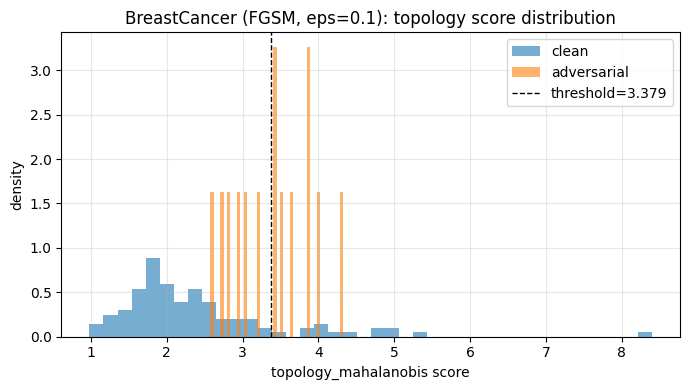

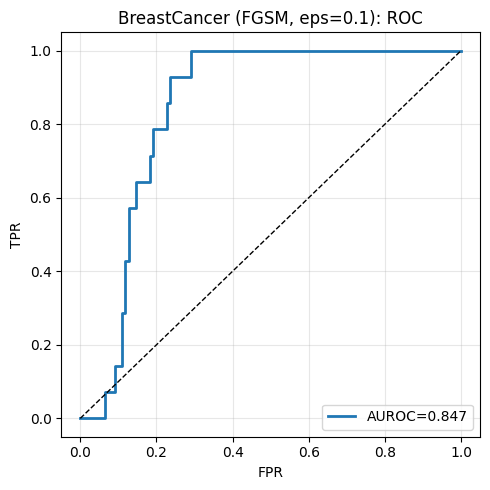

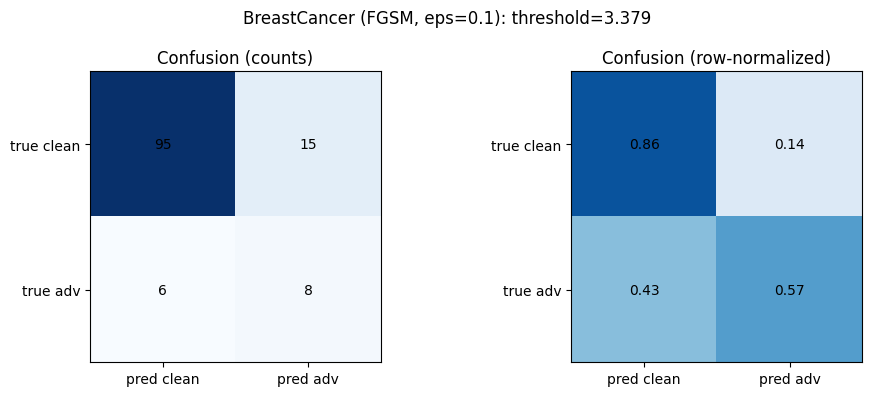

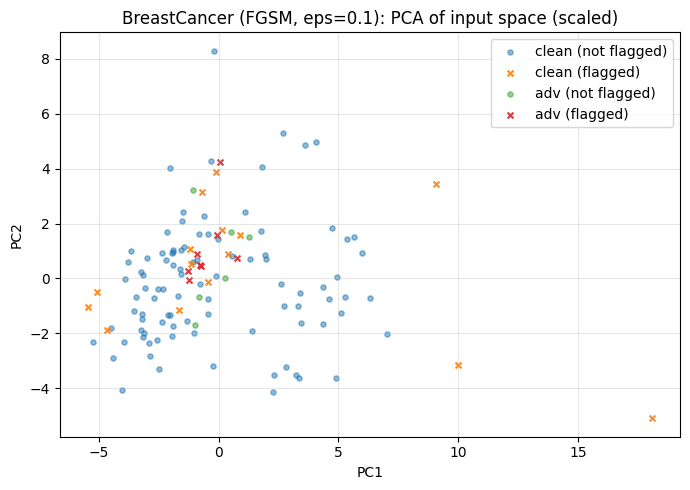

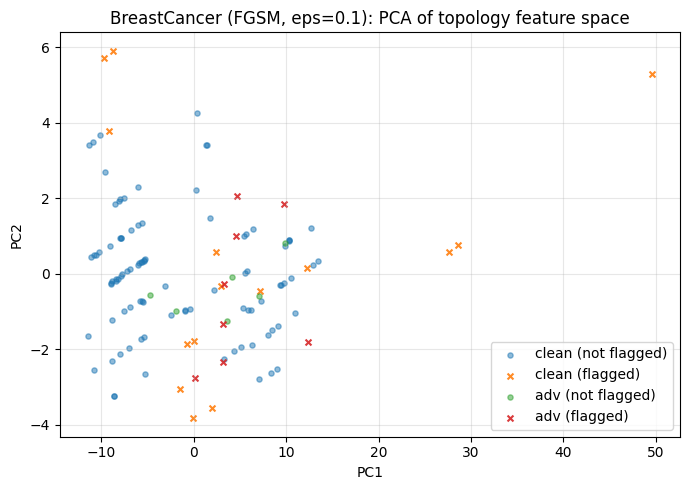

[viz] Test success: 40/250 = 0.160
[viz] Val success: 38/250 = 0.152


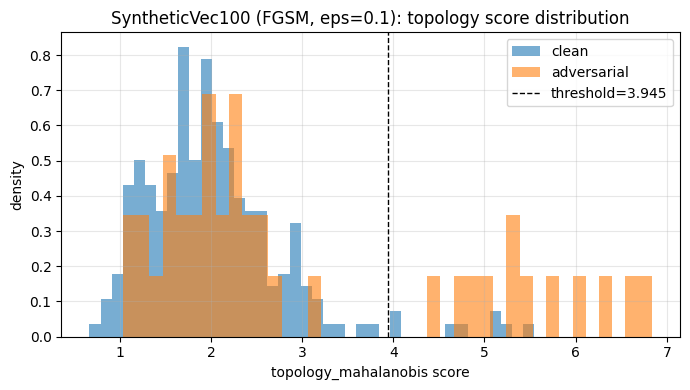

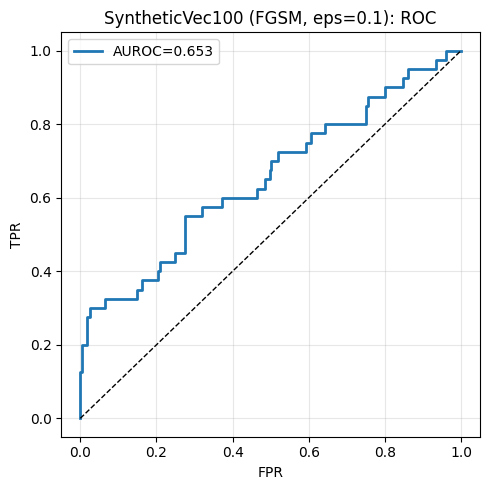

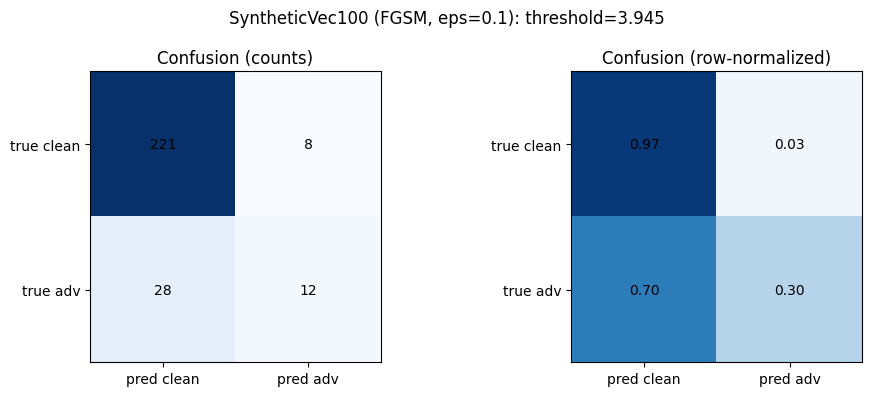

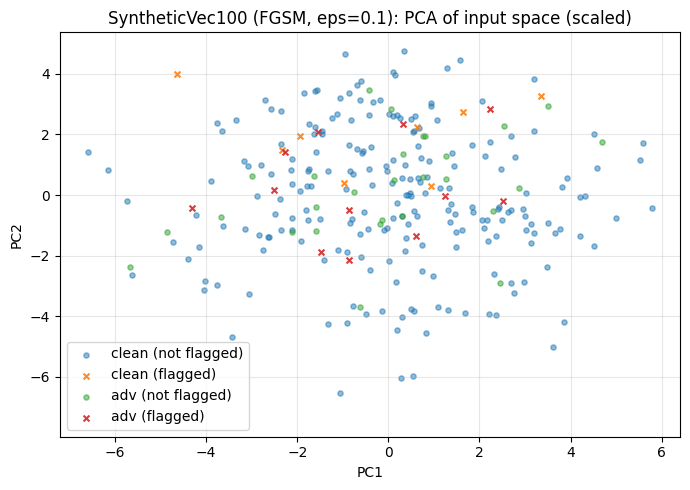

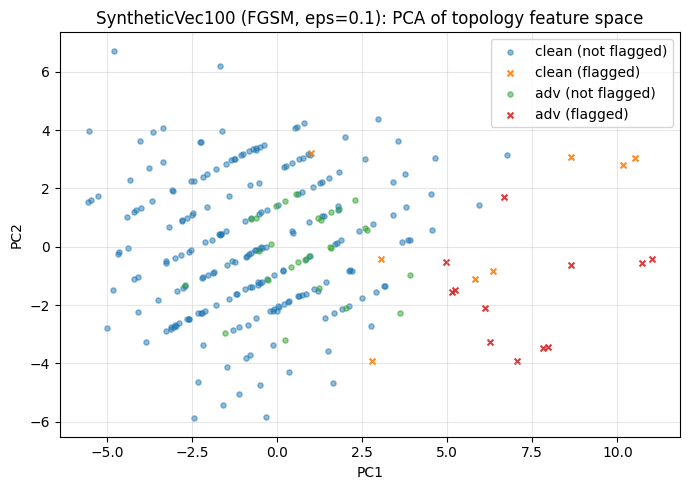

In [35]:
# Generate figures (pick one representative run per dataset for slides)

# Tabular (Breast Cancer) – FGSM
bundle_bc = run_topology_detector_bundle(
    np.asarray(X_tab, dtype=float), np.asarray(y_tab, dtype=int),
    name='BreastCancer (FGSM, eps=0.1)',
    seed=42,
    attack_type='fgsm',
    epsilon=0.1,
    n_for_scoring=200,
)

plot_score_hist(bundle_bc)
plot_roc_curve(bundle_bc)
plot_confusion_matrix(bundle_bc)
plot_pca_inputs(bundle_bc)
plot_pca_topology_features(bundle_bc)

# Vector (Synthetic 100D) – FGSM
bundle_vec = run_topology_detector_bundle(
    np.asarray(X_vec, dtype=float), np.asarray(y_vec, dtype=int),
    name='SyntheticVec100 (FGSM, eps=0.1)',
    seed=7,
    attack_type='fgsm',
    epsilon=0.1,
    n_for_scoring=250,
)

plot_score_hist(bundle_vec)
plot_roc_curve(bundle_vec)
plot_confusion_matrix(bundle_vec)
plot_pca_inputs(bundle_vec)
plot_pca_topology_features(bundle_vec)

